(two-means-notebook)=
# Test t di Student per campioni indipendenti 

In questo capitolo, esamineremo il test $t$ di Student per campioni indipendenti, uno dei test statistici frequentisti più ampiamente utilizzati nella pratica.

In [1]:
import arviz as az
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import ttest_ind
import pingouin as pg

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

Il test t di Student per due campioni indipendenti è un metodo statistico utilizzato per determinare se le medie di due campioni indipendenti sono significativamente diverse. Questo test si applica quando i due campioni sono estratti da popolazioni diverse e non vi è alcuna correlazione tra le osservazioni di un campione e quelle dell'altro.

Per condurre il test t di Student per due campioni indipendenti, calcoliamo la differenza tra le medie dei due campioni e le stime delle varianze campionarie delle rispettive popolazioni. L'ipotesi nulla del test è che le medie dei due campioni siano uguali, mentre l'ipotesi alternativa a due code è che le medie dei due campioni siano diverse. La statistica del test t viene calcolata come il rapporto tra la differenza delle medie campionarie e la deviazione standard media campionaria.

Successivamente, confrontiamo la statistica t con la distribuzione t di Student con $n_1 + n_2 - 2$ gradi di libertà, dove $n_1$ e $n_2$ sono le dimensioni dei due campioni. Calcoliamo quindi il valore-p dalla distribuzione t per determinare la significatività del test.

Esistono due approcci per stimare la varianza. Se assumiamo che le due popolazioni abbiano la stessa varianza (omoschedasticità), utilizziamo una stima *pooled* della varianza. Questo metodo è considerato efficiente quando l'omoschedasticità è verificata. Invece, se supponiamo che le due popolazioni abbiano varianze diverse, utilizziamo due stime separate delle varianze per i due campioni, chiamato test di Welch. Questo approccio è più robusto quando le varianze dei due gruppi sono significativamente diverse.

Le principali assunzioni del test t di Student per due campioni indipendenti sono l'indipendenza dei due campioni e la normalità della distribuzione delle popolazioni da cui sono stati estratti i campioni.

Di seguito è riportato il calcolo della stima della deviazione standard *pooled*, utilizzata per standardizzare la differenza tra le medie dei due campioni quando l'assunzione di omoschedasticità è verificata:

$$
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}},
$$

dove $s_p$ è la deviazione standard *pooled*, $n_0$ e $n_1$ sono le dimensioni dei due campioni, $s^2_0$ e $s^2_1$ sono le varianze campionarie dei due gruppi.

La statistica del test t è quindi calcolata come:

$$
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}},
$$

dove $\bar{x}_0$ e $\bar{x}_1$ sono le medie campionarie dei due gruppi.

Esaminiamo un esempio concreto. Supponiamo di disporre di nove misure del peso per un gruppo di donne e di nove misure di peso per un gruppo di uomini. Ci chiediamo se, nella popolazione, la media del peso dei due gruppi sia diversa.

Creiamo due array con i dati e li inseriamo in un DataFrame.

In [3]:
women_weight = np.array([38.9, 61.2, 73.3, 21.8, 63.4, 64.6, 48.4, 48.8, 48.5])
men_weight = np.array([67.8, 60, 63.4, 76, 89.4, 73.3, 67.3, 61.3, 62.4])

weight = np.concatenate((women_weight, men_weight))
print(weight)

[38.9 61.2 73.3 21.8 63.4 64.6 48.4 48.8 48.5 67.8 60.  63.4 76.  89.4
 73.3 67.3 61.3 62.4]


Creaiamo una variabile che specifica l'appartenenza al gruppo.

In [4]:
is_female = np.repeat([1, 0], 9)
is_female

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
df = pd.DataFrame({"is_female": is_female, "weight": weight})
df

,is_female,weight
0,1,38.9
1,1,61.2
2,1,73.3
3,1,21.8
4,1,63.4
5,1,64.6
6,1,48.4
7,1,48.8
8,1,48.5
9,0,67.8


Qui sotto è riportato un KDE plot per i dati di tutto il campione.

Text(0, 0.5, 'Density')

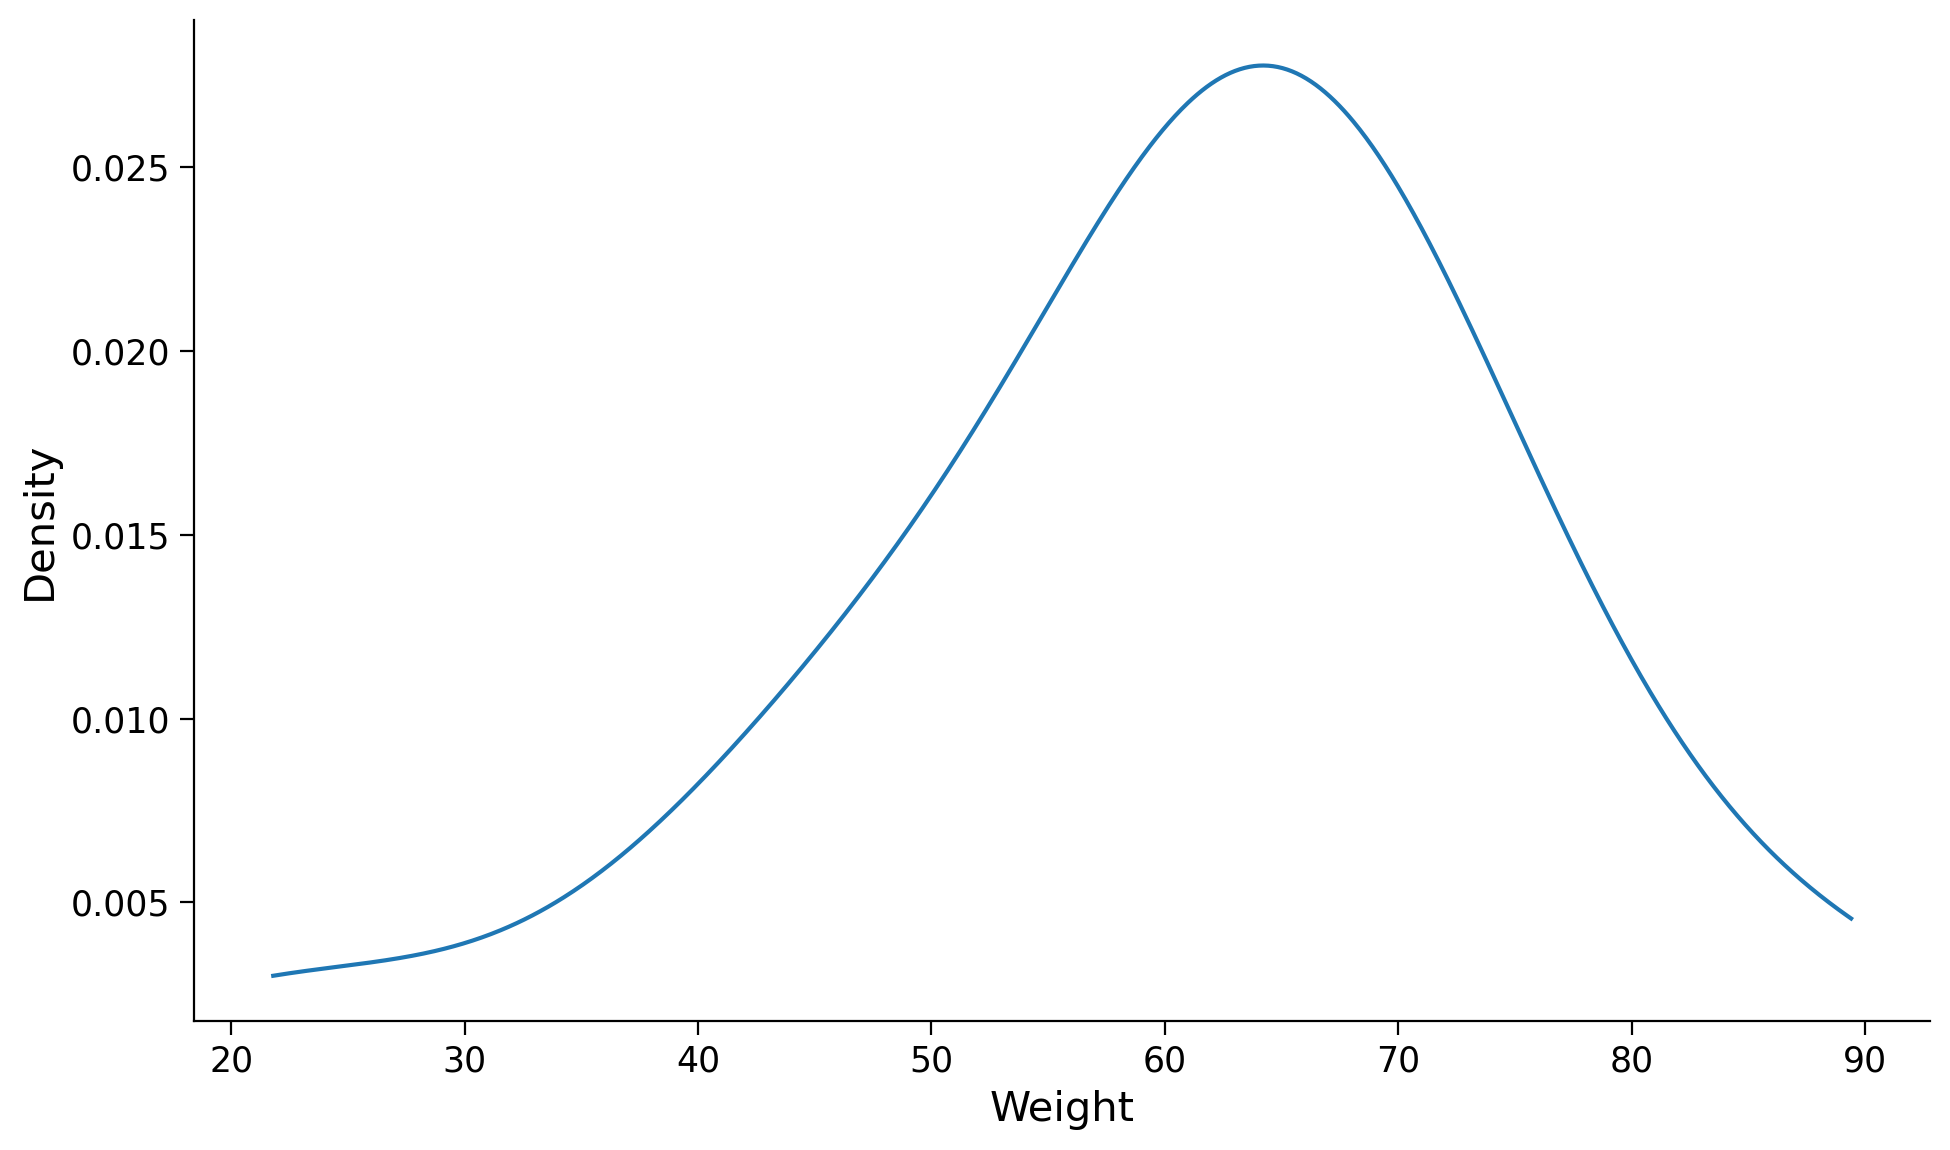

In [8]:
density = gaussian_kde(df["weight"])
x_vals = np.linspace(min(df["weight"]), max(df["weight"]), 1000)
density = density.evaluate(x_vals)

plt.plot(x_vals, density)
plt.xlabel('Weight')
plt.ylabel('Density')

Dal DataFrame estraiamo due array contenenti i valori dei pesi dei due gruppi.

In [8]:
weight_f = df.loc[df["is_female"] == 1, "weight"]
weight_m = df.loc[df["is_female"] == 0, "weight"]

Calcoliamo la deviazione standard *pooled*.

In [9]:
s_pool_num = np.sum(
    [
        (len(weight_f) - 1) * np.std(weight_f, ddof=1) ** 2,
        (len(weight_m) - 1) * np.std(weight_m, ddof=1) ** 2,
    ]
)
s_pool_denom = len(weight_f) + len(weight_m) - 2

s_pool = np.sqrt(np.divide(s_pool_num, s_pool_denom))
s_pool

12.86771368796942

Calcoliamo la statistica test.

In [10]:
t_num = np.mean(weight_f) - np.mean(weight_m)
t_denom = s_pool * np.sqrt(1 / len(weight_f) + 1 / len(weight_m))
T = np.divide(t_num, t_denom)
T

-2.7842353699254567

I gradi di libertà sono:

In [11]:
len(weight_f) + len(weight_m) - 2

16

Il valore-p è uguale a

In [12]:
stats.t.cdf(T, df=16) * 2

0.013265602643801042

Rifacciamo ora i calcoli usando la funzione `ttest` del pacchatto `pingouin`. L'argomento `paired = False` specifica che i due campioni sono indipendenti; l'argomento `correction=False` specifica che non verrà usata la correzione di Welch per varianze separate.

In [13]:
res = pg.ttest(weight_m, weight_f, paired=False, correction=False)
print(res)

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  2.784235   16   two-sided  0.013266  [4.03, 29.75]  1.312501  4.251   

           power  
T-test  0.743519  


Il risultato conferma quanto trovato in precedenza attraverso i calcoli effettuati. Il valore-$p$ indica che possiamo rifiutare l'ipotesi nulla di uguaglianza delle medie delle due popolazioni. Quindi, possiamo concludere con un livello di confidenza del 95% che la media del peso dei maschi nella popolazione è superiore alla media del peso delle femmine nella popolazione.

## Watermark

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Aug 16 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

seaborn   : 0.12.2
numpy     : 1.25.2
pandas    : 2.0.3
pingouin  : 0.5.3
scipy     : 1.11.1
matplotlib: 3.7.2
arviz     : 0.16.1

Watermark: 2.4.3

